# Выбор локации для скважины

Добывающей компании «...Нефть» нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Содержание

* [Введение](#chapter0)
* [1. Загрузка и подготовка данных](#chapter1)
* [2. Обучение и проверка модели ML](#chapter2)
* [3. Подготовка к расчёту прибыли](#chapter3)
* [4. Расчёт прибыли и рисков техникой Bootstrap](#chapter4)

# Введение <a class="anchor" id="chapter0"></a>
Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Мы построим модель для определения региона, где добыча принесёт наибольшую прибыль. Кроме того, проанализируем возможную прибыль и риски техникой Bootstrap.

## 1. Загрузка и подготовка данных <a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from numpy.random import RandomState

In [2]:
# Загрузим и подготовим данные согласно регионов
data0 = pd.read_csv('/datasets/geo_data_0.csv')
data1 = pd.read_csv('/datasets/geo_data_1.csv')
data2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
# проанализируем данные
display(data0.info())
display(data1.info())
display(data2.info())
display(data1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Вывод: <br>
1) пропусков нет,  <br>
2) столбцы id не несут полезной для нас информации, их можно удалить <br>
3) тип данных float в остальных столбцах устроит нас для проеведения анализа и расчетов <br>
4) количество строк по каждому региону одинаковое, что позволяет нам сравнивать их

In [3]:
# так как столбцы id не несут полезной для нас информации, удалим их
data0 = data0.drop(['id'], axis=1)
data1 = data1.drop(['id'], axis=1)
data2 = data2.drop(['id'], axis=1)

,product_min,product_mean,product_median,product_max,product_sum
0,0.0,92.500,91.849972,185.364347,9250000.0
1,0.0,68.825,57.085625,137.945408,6882500.0
2,0.0,95.000,94.925613,190.029838,9500000.0


<function matplotlib.pyplot.show(close=None, block=None)>

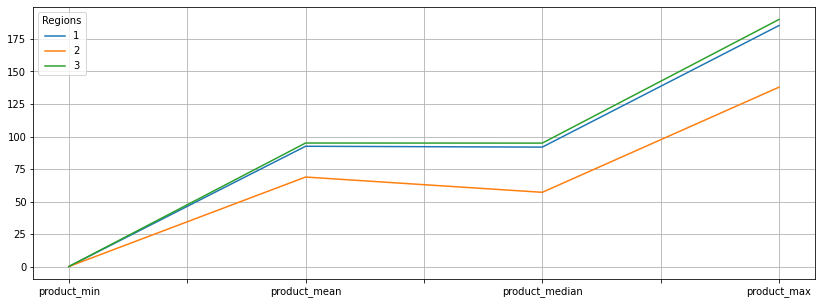

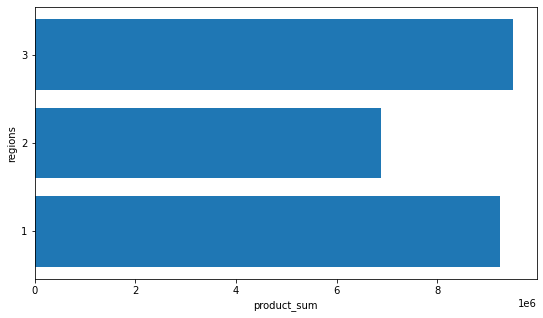

In [14]:
# для наглядности построим свобную таблицу по объемам запасов
product_table = pd.concat([
    pd.Series(
    [data0['product'].min(), 
     data1['product'].min(), 
     data2['product'].min()], name='product_min'),
    
    pd.Series(
    [data0['product'].mean(), 
     data1['product'].mean(), 
     data2['product'].mean()], name='product_mean'),
    
    pd.Series(
    [data0['product'].median(), 
     data1['product'].median(), 
     data2['product'].median()], name='product_median'),
    
    pd.Series(
    [data0['product'].max(), 
     data1['product'].max(), 
     data2['product'].max()], name='product_max'),
    
    pd.Series(
    [data0['product'].sum(), 
     data1['product'].sum(), 
     data2['product'].sum()], name='product_sum')],
                axis=1
)
       
display(product_table)

# построим график для наглядности
product_table.drop('product_sum', axis=1).T.plot(figsize=(14,5))
plt.legend([1,2,3], title='Regions')
plt.grid()
plt.show

# построим график для product_sum отдельно, так как большие значения
plt.figure(figsize=(9,5))
plt.ylabel('regions')
plt.xlabel('product_sum')
plt.barh([1,2,3],product_table['product_sum'])
plt.yticks([1,2,3])
plt.show



Вывод: максимальные значения средних, медианных, максимальных и суммарных значений в 3-м регионе. Далее проверим какой регион все же самый прибыльный.

## 2. Обучение и проверка модели ML  <a class="anchor" id="chapter2"></a>

In [14]:
# для построения моделей
# разделим на обучающую и валидационную выборки data0 (данные по первому региону)
target0 = data0['product']
features0 = data0.drop('product', axis=1)

features_train0, features_valid0, target_train0, target_valid0 = train_test_split(
    features0, 
    target0, 
    test_size=0.25, # Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
    random_state=12345) 

print('Проверка разбиения данных:')
print('data0' , data0.shape)
print('features_train0' , features_train0.shape)
print('features_valid0' , features_valid0.shape)
print()

# разделим на обучающую и валидационную выборки data1 (данные по второму региону)
target1 = data1['product']
features1 = data1.drop('product', axis=1)

features_train1, features_valid1, target_train1, target_valid1 = train_test_split(
    features1, 
    target1, 
    test_size=0.25,
    random_state=12345) 

print('Проверка разбиения данных:')
print('data1' , data1.shape)
print('features_train1' , features_train1.shape)
print('features_valid1' , features_valid1.shape)
print()

# разделим на обучающую и валидационную выборки data2 (данные по третьему региону)
target2 = data2['product']
features2 = data2.drop('product', axis=1)

features_train2, features_valid2, target_train2, target_valid2 = train_test_split(
    features2, 
    target2, 
    test_size=0.25,
    random_state=12345) 

print('Проверка разбиения данных:')
print('data2' , data2.shape)
print('features_train2' , features_train2.shape)
print('features_valid2' , features_valid2.shape)
print()


Проверка разбиения данных:
data0 (100000, 4)
features_train0 (75000, 3)
features_valid0 (25000, 3)

Проверка разбиения данных:
data1 (100000, 4)
features_train1 (75000, 3)
features_valid1 (25000, 3)

Проверка разбиения данных:
data2 (100000, 4)
features_train2 (75000, 3)
features_valid2 (25000, 3)



In [20]:
# отмасштабируем признаки, так как будем применять линейную регрессию
scaler0 = StandardScaler()
scaler0.fit(features_train0)
features_train_scaled0 = scaler0.transform(features_train0)
features_valid_scaled0 = scaler0.transform(features_valid0)

scaler1 = StandardScaler()
scaler1.fit(features_train1)
features_train_scaled1 = scaler1.transform(features_train1)
features_valid_scaled1 = scaler1.transform(features_valid1)

scaler2 = StandardScaler()
scaler2.fit(features_train2)
features_train_scaled2 = scaler2.transform(features_train2)
features_valid_scaled2 = scaler2.transform(features_valid2)


In [21]:
model0 = LinearRegression()
model0.fit(features_train0, target_train0)
predictions0 = model0.predict(features_valid0)
result0 = mean_squared_error(target_valid0, predictions0)**1/2
print('RMSE 0 модели = ', result0)
print('Средний запас сырья = ', predictions0.mean())

model1 = LinearRegression()
model1.fit(features_train0, target_train1)
predictions1 = model1.predict(features_valid1)
result1 = mean_squared_error(target_valid1, predictions1)**1/2
print('RMSE 1 модели', result1)
print('Средний запас сырья = ', predictions1.mean())

model2 = LinearRegression()
model2.fit(features_train2, target_train2)
predictions2 = model2.predict(features_valid2)
result2 = mean_squared_error(target_valid2, predictions2)**1/2
print('RMSE 2 модели', result2)
print('Средний запас сырья = ', predictions2.mean())



RMSE 0 модели =  706.1064682199622
Средний запас сырья =  92.59256778438035
RMSE 1 модели 1061.419600768847
Средний запас сырья =  71.28359507581449
RMSE 2 модели 801.1887906618098
Средний запас сырья =  94.96504596800489


Вывод: Точность предсказания моделей(RMSE) сопоставима, хорошие показатели для 1 и 3 регионов(706 и 801) и немного хуже для 2 региона(1061). Средний запас больше всего для 3 региона и меньше всего для 2.

## 3. Подготовка к расчёту прибыли <a class="anchor" id="chapter3"></a>

### Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины


Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. 
Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [23]:
budget = 10 * (10**6) # Бюджет на разработку скважин в регионе, рублей
product_profit = 450000 # Доход с каждой единицы продукта
breakeven_point = budget / product_profit / 200  # делим также на 200, так как для точки считаем
print('Точка безубыточности = ', round(breakeven_point,3), ' тыс. баррелей')

Точка безубыточности =  0.111  тыс. баррелей


Вывод:средний запас всех трех регионов(92, 71, 94) намного превосходит точку безубыточности(0,111)

## 4. Расчёт прибыли и рисков техникой Bootstrap  <a class="anchor" id="chapter4"></a>

### Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [33]:
#функция суммирует запасы 200 скважин с наилучшими показателями и переводит в прибыль 
# из расчета, что при нынешних ценах один баррель сырья приносит 450 рублей дохода
# прибыль  будем считать в миллиардах
def profit(wells):
    return pd.Series(wells).sort_values(ascending=False)[:200].sum() * 450000 / (10**9)

# функция расчета риска убытков
# риск считаем как долю убыточных скважин от общего количества скважин. 
# Долю убыточных скважин считаем как операционная прибыль, посчитанная фуекцией profit, минус инвестиции 10
def loss_risk(profit_values):
    values = pd.Series(profit_values) - 10
    return values[values<0].count() / values.count()



### Посчитаем риски и прибыль для каждого региона

In [35]:
state=np.random.RandomState(12345)
values = [] # создадим список для прибылей
region = 1 # Будем перебирать номер региона с 1 по 3
for features_valid in [features_valid0, features_valid1, features_valid2]:
    if region == 1: # для каждого региона своя модель, созданная ранее
        model = model0
    if region == 2:
        model = model1
    if region == 3:
        model = model2    
        
    for i in range(1000): # Применим технику Bootstrap с 1000 выборок
        # создадим подвыборку, при разведке региона исследуют 500 точек
        subsample = features_valid.sample(n=500, replace=True, random_state=state) 
        predictions = model.predict(subsample) #предсказываем для созданной подвыборки прибыль при помощи модели
        values.append(profit(predictions))
    lower = pd.Series(values).quantile(q=0.025) # нижний предел доверительного интервала
    upper = pd.Series(values).quantile(q=0.975) # верхний предел доверительного интервала
    mean = pd.Series(values).mean() # среднее значение прибыли
    loss_risk_value = loss_risk(values)
    print('для ', region, 'региона: ') 
    print('доверительный интервал между ', round(lower,1), ' и ', round(upper,1), 
          ', среднее значение прибыли: ', round(mean,1), 'млрд руб,', 'риск убытков:', loss_risk_value)
    region += 1
    

для  1 региона: 
доверительный интервал между  10.1  и  10.6 , среднее значение прибыли:  10.4 млрд руб, риск убытков: 0.001
для  2 региона: 
доверительный интервал между  6.6  и  10.6 , среднее значение прибыли:  8.5 млрд руб, риск убытков: 0.5005
для  3 региона: 
доверительный интервал между  6.6  и  10.5 , среднее значение прибыли:  9.1 млрд руб, риск убытков: 0.334


**Вывод:** <br> 
Максимальную прибыль показывает 1-й регион, с 95% вероятности прибыль будет в пределах от 10,1 до 10,6 млрд рублей со средним значение 10,4 млрд рублей. Риска получить убыток практически нет, так как инвестиции 10 млрд рублей ниже потенциальной прибыли практически на всех точках.